## Plan

This tutorial shows how to

* optimize the reactant state,
* perform a PES Scan to get a good starting structure for transition state search,
* perform a transition state search,
* extract the barrier

Note that this tutorial only shows one half of a reaction.

## Initial imports

In [1]:
from scm.libbase import ChemicalSystem
from scm.plams import view, Settings, AMSJob

## Initial system

mol.charge=1.0


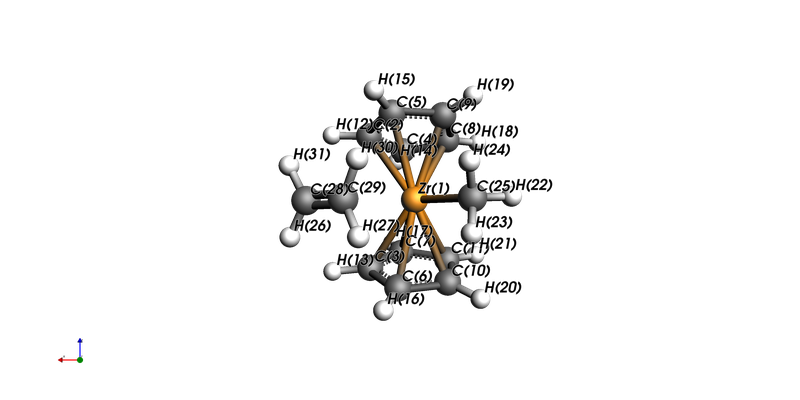

In [2]:
mol = ChemicalSystem(
    """
System
    Charge 1.0
    Atoms
        Zr       1.60682759      -9.09697636       1.29667400
        C       2.89496678     -10.06750666       3.11673910
        C       2.84805610      -9.90469975      -0.63831357
        C       1.91952398     -11.03393562       2.76898899
        C       2.21720521      -8.93716871       3.64709384
        C       2.05919385      -8.80831375      -1.07706558
        C       1.96898612     -10.95146163      -0.26897070
        C       0.63990901     -10.49043590       3.04466191
        C       0.82713373      -9.20286661       3.61113029
        C       0.69607878      -9.17611676      -0.96529901
        C       0.63812917     -10.49403820      -0.44270184
        H       3.96827494     -10.23973626       3.15013890
        H       3.92582990      -9.99794535      -0.74784951
        H       2.12190386     -12.06174102       2.48123664
        H       2.68569500      -8.09238646       4.14547290
        H       2.43329579      -7.91168000      -1.56456659
        H       2.26368032     -11.97103749      -0.03692581
        H      -0.30289388     -11.03081473       2.99676260
        H       0.05404650      -8.59747583       4.07520644
        H      -0.14620660      -8.61151792      -1.35464113
        H      -0.25838864     -11.10457655      -0.36003217
        H      -0.85662057      -7.76723654       1.38227139
        H       0.26321351      -6.74399730       0.47215750
        H       0.31659006      -6.75672110       2.23713123
        C       0.17801499      -7.39347280       1.35339060
        H       4.83158681      -7.79302616       0.33628574
        H       2.98632816      -6.14645123       0.41958259
        C       4.37932750      -7.48955975       1.27484960
        C       3.37901781      -6.61143075       1.32052856
        H       3.01865674      -6.20459134       2.26225286
        H       4.86414560      -7.85327440       2.17514370
    End
End"""
)
mol.guess_bonds()
print(f"{mol.charge=}")
view(mol, direction="along_y", show_atom_labels=True, atom_label_type="Name")

## DFTB Settings

In [3]:
from scm.plams import Settings, AMSJob


def get_dftb_settings():
    # Engine settings: GFN-1xTB with implicit Tolene solvation
    settings = Settings()
    settings.input.DFTB.Model = "GFN1-xTB"
    settings.input.DFTB.Solvation.Solvent = "Toluene"
    return settings


print(AMSJob(settings=get_dftb_settings()).get_input())


Engine DFTB
  Model GFN1-xTB
  Solvation
    Solvent Toluene
  End
EndEngine




## Geometry optimization of reactant state

In [4]:
def get_reactants_job(mol):
    settings = get_dftb_settings()
    settings.input.ams.Task = "SinglePoint"
    settings.input.ams.Properties.NormalModes = "Yes"
    job = AMSJob(molecule=mol, settings=settings, name="reactants_frequencies")
    return job


reactants_job = get_reactants_job(mol)
reactants_job.run();

[11.11|14:48:22] JOB reactants_frequencies STARTED
[11.11|14:48:22] JOB reactants_frequencies RUNNING
[11.11|14:48:25] JOB reactants_frequencies FINISHED
[11.11|14:48:25] JOB reactants_frequencies SUCCESSFUL


## Set up PES Scan to find approximate transition state

In [5]:
def get_pesscan_job(mol):
    # Engine settings: GFN-1xTB with implicit Tolene solvation
    settings = get_dftb_settings()

    # AMS settings for PES scan (see online tutorial for choice of scan coordinates)
    settings.input.ams.Task = "PESScan"
    settings.input.ams.PESScan.ScanCoordinate.nPoints = "20"
    settings.input.ams.PESScan.ScanCoordinate.Distance = ["1 28 3.205 2.3", "29 25 3.295 1.5"]

    # Loosened convergence criteria
    settings.input.ams.GeometryOptimization.Convergence.Energy = "5.0e-5 [Hartree]"
    settings.input.ams.GeometryOptimization.Convergence.Gradients = "5.0e-3"
    settings.input.ams.GeometryOptimization.Convergence.Step = "5.0e-3 [Angstrom]"

    # setting up the AMS job with the molecule and settings object
    job = AMSJob(molecule=mol, settings=settings, name="pes_scan")
    return job

    # run the calulation


pesscan_job = get_pesscan_job(reactants_job.results.get_main_system())
pesscan_job.run();

[11.11|14:48:25] JOB pes_scan STARTED
[11.11|14:48:25] JOB pes_scan RUNNING
[11.11|14:48:54] JOB pes_scan FINISHED
[11.11|14:48:54] JOB pes_scan SUCCESSFUL


## PESScan results

In [13]:
import matplotlib.pyplot as plt
from pprint import pprint

pesscan_results = pesscan_job.results.get_pesscan_results()
pprint(pesscan_results, depth=1)

{'ConstrainedAtoms': {1, 28, 29, 25},
 'Converged': [...],
 'HistoryIndices': [...],
 'Molecules': [...],
 'OrigScanCoords': [...],
 'PES': [...],
 'Properties': [],
 'RaveledPESCoords': [...],
 'RaveledScanCoords': [...],
 'RaveledUnits': [...],
 'ScanCoords': [...],
 'Units': [...],
 'nPESPoints': 20,
 'nRaveledScanCoords': 2,
 'nScanCoords': 1}


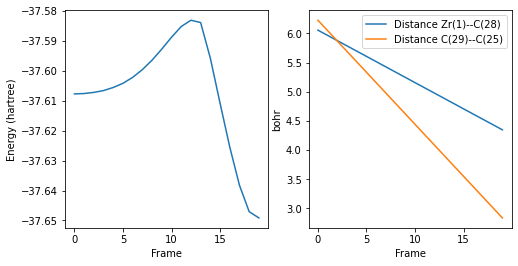

In [6]:
fix, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(list(range(pesscan_results["nPESPoints"])), pesscan_results["PES"])
ax[0].set_ylabel("Energy (hartree)")
ax[0].set_xlabel("Frame")
for i in range(pesscan_results["nRaveledScanCoords"]):
    ax[1].plot(
        list(range(pesscan_results["nPESPoints"])),
        pesscan_results["RaveledPESCoords"][i],
        label=pesscan_results["RaveledScanCoords"][i],
    )
ax[1].set_ylabel("bohr")
ax[1].set_xlabel("Frame")
ax[1].legend();

Highest energy: -37.583147 hartree, for geometry #13
We will use that structure as starting point for TS search


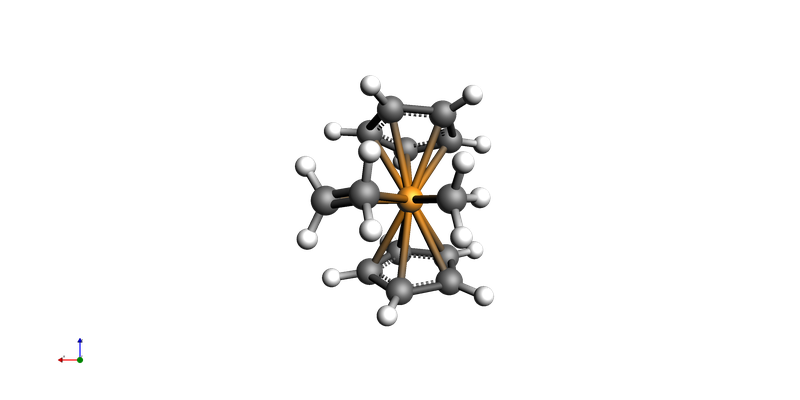

In [7]:
import numpy as np

highest_energy = np.max(pesscan_results["PES"])
highest_energy_index = np.argmax(pesscan_results["PES"])

# res['Molecules'] contains all the converged geometries (as PLAMS Molecules)
highest_energy_geo = pesscan_results["Molecules"][highest_energy_index]

print(f"Highest energy: {highest_energy:.6f} hartree, for geometry #{highest_energy_index+1}")
print("We will use that structure as starting point for TS search")
highest_energy_geo.guess_bonds()
view(highest_energy_geo, direction="along_y")

## Transition state search

[11.11|14:48:56] JOB ts_search STARTED
[11.11|14:48:56] JOB ts_search RUNNING
[11.11|14:49:07] JOB ts_search FINISHED
[11.11|14:49:07] JOB ts_search SUCCESSFUL


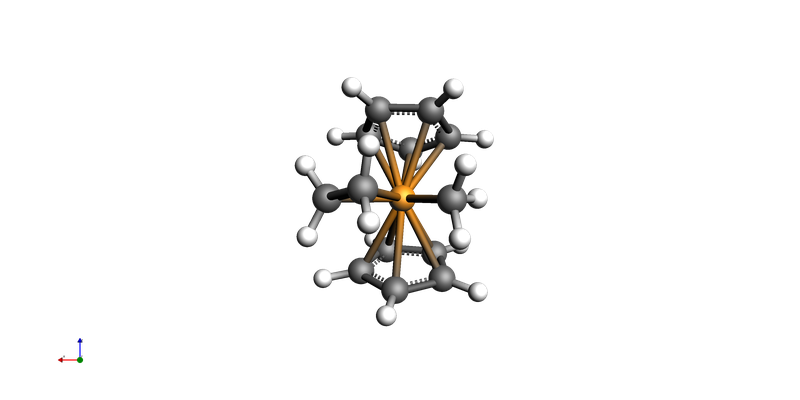

In [8]:
def get_ts_job(mol):
    settings = get_dftb_settings()

    # AMS settings for TS search
    settings.input.ams.Task = "TransitionStateSearch"
    settings.input.ams.Properties.NormalModes = "Yes"
    settings.input.ams.GeometryOptimization.InitialHessian.Type = "Calculate"

    # setting up the AMS job with the molecule and settings object
    job = AMSJob(molecule=mol, settings=settings, name="ts_search")
    return job


ts_job = get_ts_job(highest_energy_geo)
ts_job.run()
ts_mol = ts_job.results.get_main_system()
ts_mol.guess_bonds()
view(ts_mol, direction="along_y")

In [9]:
def get_gibbs_energy(job: AMSJob, unit="hartree"):
    from scm.libbase import Units

    gibbs_energy = job.results.readrkf("Thermodynamics", "Gibbs free Energy", file="engine")
    gibbs_energy *= Units.convert("hartree", unit, 1.0)
    return gibbs_energy


def print_ts_results(job):
    energy = job.results.get_energy(unit="kcal/mol")
    gibbs_energy = get_gibbs_energy(job, unit="kcal/mol")
    frequencies = job.results.get_frequencies(unit="cm^-1")
    character = job.results.readrkf("AMSResults", "PESPointCharacter", file="engine")

    # print results
    print("== Results ==")
    print("Character   : {}".format(character))
    print("Energy      : {:.3f} kcal/mol".format(energy))
    print("Gibbs Energy: {:.3f} kcal/mol".format(gibbs_energy))
    for freq in frequencies:
        if freq < 0:
            print("Imaginary frequency : {:.3f} cm^-1".format(freq))
        else:
            break


print_ts_results(ts_job)

== Results ==
Character   : transition state
Energy      : -23587.067 kcal/mol
Gibbs Energy: -23460.913 kcal/mol
Imaginary frequency : -397.387 cm^-1


## Free energy barrier

In [10]:
def print_final_results(gibbs_energy_ts: float, gibbs_energy_reactants: float, T=298.15):
    barrier = gibbs_energy_ts - gibbs_energy_reactants  # kJ/mol
    NA = 6.022e23  # Avogadro's constant
    k_B = 1.380649e-23  # Boltzmann constant, J / (mol*K)
    h = 6.626e-34  # Planck's constant, J * s
    rate_constant = (k_B * T / h) * np.exp(-barrier * 1000 / (NA * k_B * T))
    print("Results summary")
    print("Reactants Gibbs Energy: {:.3f} kJ/mol".format(gibbs_energy_reactants))
    print("TS Gibbs Energy:        {:.3f} kJ/mol".format(gibbs_energy_ts))
    print("Free energy barrier:    {:.3f} kJ/mol".format(barrier))
    print("Rate constant:          {:.3f} s⁻¹ at {} K".format(rate_constant, T))


gibbs_energy_ts = get_gibbs_energy(ts_job, "kJ/mol")
gibbs_energy_reactants = get_gibbs_energy(reactants_job, "kJ/mol")
print_final_results(gibbs_energy_ts, gibbs_energy_reactants, T=298.15)

Results summary
Reactants Gibbs Energy: -98216.185 kJ/mol
TS Gibbs Energy:        -98160.461 kJ/mol
Free energy barrier:    55.724 kJ/mol
Rate constant:          1073.256 s⁻¹ at 298.15 K
